## Recommendation of Solutions for Resolving Gradle Build Errors

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Data Load

In [3]:
df = pd.read_csv('Data/gradle-build-fauilure-msg.csv')
df = df.dropna(thresh=1)
df = df.fillna(0)
df = df.reset_index(drop=True)
number_of_label = df.groupby('label').size()
number_of_label

label
0.0     39
1.0     39
2.0     10
3.0     59
4.0      6
5.0     12
6.0      2
7.0     29
8.0      3
9.0      2
10.0    69
11.0    17
12.0     7
13.0     2
dtype: int64

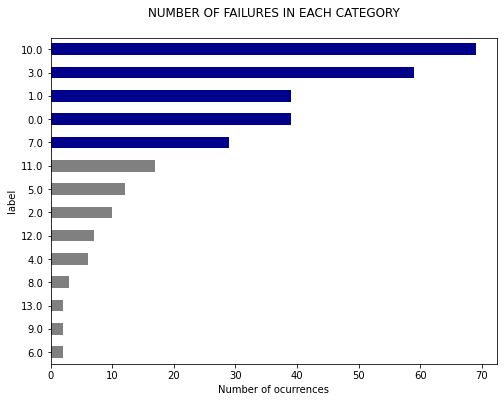

In [120]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey', 'grey','grey',
          'darkblue','darkblue','darkblue','darkblue','darkblue']
df.groupby('label').size().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF FAILURES IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## Data Preprocessing

In [122]:
 def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [123]:
df['cleanText']=df['error'].map(lambda s:preprocess(s))

In [124]:
X = df.cleanText
y = df.label
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state = 2)

In [111]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Vectorization

### Bag of Words

In [137]:
cv = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
# cv = CountVectorizer()
features = cv.fit_transform(df['cleanText']).toarray()
labels = df['label']

### TF-IDF

In [ ]:
tv = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3),
                        stop_words='english')

# features = tv.fit_transform(df['cleanText']).toarray()
features = tv.fit_transform(df['cleanText']).toarray()
labels = df['label']

print("Each of the %d errors is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

### Bag of Words + TF-IDF

In [136]:
p1 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=100,  random_state=0))
              ])
p2 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])
p3 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(random_state=0))
              ])
p4 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC(C=1.0))
              ])
p5 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))
              ])
p6 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf', svm.SVC(kernel='rbf'))
              ])
p7 = Pipeline([('vect', CountVectorizer(max_features=1500, min_df=5, max_df=0.7)),
               ('tfidf', TfidfTransformer()),
               ('clf',     XGBClassifier( n_estimators=100,
                  objective='multi:softprob',
                  learning_rate=0.03333 ))
              ])
pipeline = [p1, p2, p3, p4, p5, p6, p7]

## Modeling

In [146]:
models = [
    RandomForestClassifier(n_estimators=100,  random_state=0),
    LinearSVC(C=1.0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    XGBClassifier( n_estimators=100,
                  objective='multi:softprob',
                  learning_rate=0.03333 ),
    svm.SVC(kernel='rbf')
]

In [139]:
# Cross-validation - Bag of wWrds, TF-IDF
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-p

In [129]:
# Cross-validation - Bag of Words + TF-IDF
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for pipe in pipeline:
    model_name = pipe.get_params()['clf'].__class__.__name__
    accuracies = cross_val_score(pipe, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaconda3/envs/mingu_p37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/tako/anaco

In [140]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.857931,0.061243
LogisticRegression,0.881839,0.069691
MultinomialNB,0.824483,0.066898
RandomForestClassifier,0.891839,0.047151
SVC,0.763103,0.065555
XGBClassifier,0.861034,0.069935


In [143]:
import seaborn as sns

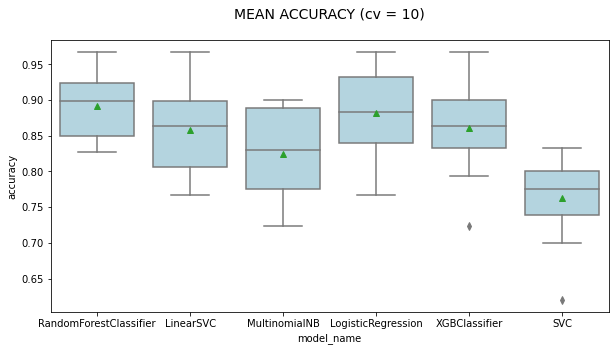

In [147]:
plt.figure(figsize=(10,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = {})\n".format(CV), size=14);